In [5]:
%matplotlib inline
import matplotlib
import seaborn as sns
import pylab as pl
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import requests
from requests_futures.sessions import FuturesSession
from bs4 import BeautifulSoup
import re
import urllib 
import zipfile
import os
import sys
import pandas as pd
sys.path.append('/usr/local/lib/python2.7/dist-packages') 
import vincent

In [2]:
#County IDs
county_fips_url='http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt'
# print response.text
county_fips=pd.read_table(county_fips_url, sep=',', header=None, names=['state_abbrev','state_fp', 'county_fp', 'countyName', 'fp_class_code'])
county_fips['st_county_id']=county_fips['state_fp']*1000+county_fips['county_fp']
county_fips['st_county_id_str']=county_fips['st_county_id'].map("{:05}".format)
print county_fips.head()

  state_abbrev  state_fp  county_fp      countyName fp_class_code  \
0           AL         1          1  Autauga County            H1   
1           AL         1          3  Baldwin County            H1   
2           AL         1          5  Barbour County            H1   
3           AL         1          7     Bibb County            H1   
4           AL         1          9   Blount County            H1   

   st_county_id st_county_id_str  
0          1001            01001  
1          1003            01003  
2          1005            01005  
3          1007            01007  
4          1009            01009  


In [3]:
# print [county_fips['state_fp']==1]
# print county_fips[[county_fips['state_fp']==1],'st_county_id_str']
def create_string_list(county_list):
#     print county_list['st_county_id_str']
    return ','.join(county_list['st_county_id_str'])
print county_fips[['state_fp','st_county_id_str']].head()
counties_stringsDF=county_fips[['state_fp','st_county_id_str']].groupby('state_fp').apply(create_string_list)
print counties_stringsDF.head()
print counties_stringsDF[1]
# counties_str=','.join(county_fips[[county_fips['state_fp']==1],st_county_id_str'])

   state_fp st_county_id_str
0         1            01001
1         1            01003
2         1            01005
3         1            01007
4         1            01009
state_fp
1    01001,01003,01005,01007,01009,01011,01013,0101...
2    02013,02016,02020,02050,02060,02068,02070,0209...
4    04001,04003,04005,04007,04009,04011,04012,0401...
5    05001,05003,05005,05007,05009,05011,05013,0501...
6    06001,06003,06005,06007,06009,06011,06013,0601...
dtype: object
01001,01003,01005,01007,01009,01011,01013,01015,01017,01019,01021,01023,01025,01027,01029,01031,01033,01035,01037,01039,01041,01043,01045,01047,01049,01051,01053,01055,01057,01059,01061,01063,01065,01067,01069,01071,01073,01075,01077,01079,01081,01083,01085,01087,01089,01091,01093,01095,01097,01099,01101,01103,01105,01107,01109,01111,01113,01115,01117,01119,01121,01123,01125,01127,01129,01131,01133


In [10]:
# www.broadbandmap.gov/broadbandmap/speedtest/county/ids/01,02?format=json
base_url='http://www.broadbandmap.gov/broadbandmap/speedtest/county/ids/'
session = FuturesSession(max_workers=15)

# multiple resolutions available:state, county, censusplace, msa, usf, statesenate, statehouse, congdistrict, tribalnation.
print counties_stringsDF.head(1)
# url=base_url+counties_strings[1]+'?format=json'
urls=(base_url+counties_stringsDF+'?format=json').tolist()

futures = [session.get(url) for url in urls]
state_responses = [future.result() for future in futures]

state_fp
1    01001,01003,01005,01007,01009,01011,01013,0101...
dtype: object


In [13]:
print state_responses[1].url
print state_responses[1].text[0:500]

http://www.broadbandmap.gov/broadbandmap/speedtest/county/ids/02013,02016,02020,02050,02060,02068,02070,02090,02100,02105,02110,02122,02130,02150,02164,02170,02180,02185,02188,02195,02198,02220,02230,02240,02261,02270,02275,02282,02290?format=json
{"status":"OK","responseTime":18,"message":["Maximum of only 10 parameters are allowed"],"Results":[{"geographyId":"02013","geographyName":"Aleutians East","accessingFrom":"Home","numberOfTests":2,"medianDownload":40.47103,"lowerQuartileDownload":21.00260,"upperQuartileDownload":59.93945,"medianUpload":16.19449,"lowerQuartileUpload":0.87598,"upperQuartileUpload":31.51300},{"geographyId":"02013","geographyName":"Aleutians East","accessingFrom":"Mobile","numberOfTests":19,"medianDownload":0.38672,


In [22]:
#check that with state with max number of counties no lost info
max_idx=county_fips[['state_fp','st_county_id_str']].groupby('state_fp').count().idxmax()
print max_idx #48
urls=(base_url+counties_stringsDF+'?format=json').tolist()
print urls[48]
example_response = requests.get(urls[48])
maxTestDF=pd.DataFrame(example_response.json()['Results'])
print maxTestDF.tail(1)
print 'received:',maxTestDF.tail(1).iloc[0,1],'last in list:', urls[48][-17:-12]

st_county_id_str    48
dtype: int64
http://www.broadbandmap.gov/broadbandmap/speedtest/county/ids/54001,54003,54005,54007,54009,54011,54013,54015,54017,54019,54021,54023,54025,54027,54029,54031,54033,54035,54037,54039,54041,54043,54045,54047,54049,54051,54053,54055,54057,54059,54061,54063,54065,54067,54069,54071,54073,54075,54077,54079,54081,54083,54085,54087,54089,54091,54093,54095,54097,54099,54101,54103,54105,54107,54109?format=json
    accessingFrom geographyId geographyName  lowerQuartileDownload  \
179        Mobile       54109       Wyoming                3.15527   

     lowerQuartileUpload  medianDownload  medianUpload  numberOfTests  \
179              0.45898          7.3667       0.46289             70   

     upperQuartileDownload  upperQuartileUpload  
179                7.58984              0.46484  
received: 54109 last in list: 54109


In [67]:
example_response.text[:1000]

u'{"status":"OK","responseTime":28,"message":["Maximum of only 10 parameters are allowed"],"Results":[{"geographyId":"54001","geographyName":"Barbour","accessingFrom":"Business","numberOfTests":3,"medianDownload":0.68760,"lowerQuartileDownload":0.60491,"upperQuartileDownload":0.72363,"medianUpload":1.01074,"lowerQuartileUpload":0.35800,"upperQuartileUpload":1.20996},{"geographyId":"54001","geographyName":"Barbour","accessingFrom":"CC_library_school","numberOfTests":1,"medianDownload":0.93475,"lowerQuartileDownload":0.93475,"upperQuartileDownload":0.93475,"medianUpload":1.15000,"lowerQuartileUpload":1.15000,"upperQuartileUpload":1.15000},{"geographyId":"54001","geographyName":"Barbour","accessingFrom":"Home","numberOfTests":9,"medianDownload":0.89258,"lowerQuartileDownload":0.54199,"upperQuartileDownload":1.58301,"medianUpload":0.40918,"lowerQuartileUpload":0.36523,"upperQuartileUpload":0.54883},{"geographyId":"54001","geographyName":"Barbour","accessingFrom":"Mobile","numberOfTests":62

In [24]:
example_response.json().keys()

[u'status', u'message', u'Results', u'responseTime']

In [25]:
example_response.json()['message']

[u'Maximum of only 10 parameters are allowed']

In [69]:
example_response.json()['Results'][0:3]

[{u'accessingFrom': u'Business',
  u'geographyId': u'54001',
  u'geographyName': u'Barbour',
  u'lowerQuartileDownload': 0.60491,
  u'lowerQuartileUpload': 0.358,
  u'medianDownload': 0.6876,
  u'medianUpload': 1.01074,
  u'numberOfTests': 3,
  u'upperQuartileDownload': 0.72363,
  u'upperQuartileUpload': 1.20996},
 {u'accessingFrom': u'CC_library_school',
  u'geographyId': u'54001',
  u'geographyName': u'Barbour',
  u'lowerQuartileDownload': 0.93475,
  u'lowerQuartileUpload': 1.15,
  u'medianDownload': 0.93475,
  u'medianUpload': 1.15,
  u'numberOfTests': 1,
  u'upperQuartileDownload': 0.93475,
  u'upperQuartileUpload': 1.15},
 {u'accessingFrom': u'Home',
  u'geographyId': u'54001',
  u'geographyName': u'Barbour',
  u'lowerQuartileDownload': 0.54199,
  u'lowerQuartileUpload': 0.36523,
  u'medianDownload': 0.89258,
  u'medianUpload': 0.40918,
  u'numberOfTests': 9,
  u'upperQuartileDownload': 1.58301,
  u'upperQuartileUpload': 0.54883}]

In [27]:
example_speed_testDF=pd.DataFrame(example_response.json()['Results'])
print example_speed_testDF.head()

       accessingFrom geographyId geographyName  lowerQuartileDownload  \
0           Business       54001       Barbour                0.60491   
1  CC_library_school       54001       Barbour                0.93475   
2               Home       54001       Barbour                0.54199   
3             Mobile       54001       Barbour                0.20605   
4           Business       54003      Berkeley                1.91443   

   lowerQuartileUpload  medianDownload  medianUpload  numberOfTests  \
0              0.35800         0.68760       1.01074              3   
1              1.15000         0.93475       1.15000              1   
2              0.36523         0.89258       0.40918              9   
3              0.10254         1.12695       1.00342             62   
4              0.46680         2.37226       0.55664              2   

   upperQuartileDownload  upperQuartileUpload  
0                0.72363              1.20996  
1                0.93475              

In [28]:
print example_speed_testDF[example_speed_testDF['accessingFrom']=='Home'].head()
print example_speed_testDF[example_speed_testDF['accessingFrom']=='Home'][['geographyId','medianDownload']].head()

   accessingFrom geographyId geographyName  lowerQuartileDownload  \
2           Home       54001       Barbour                0.54199   
5           Home       54003      Berkeley                1.38184   
9           Home       54005         Boone                1.91992   
11          Home       54007       Braxton                0.79297   
15          Home       54009        Brooke                2.22919   

    lowerQuartileUpload  medianDownload  medianUpload  numberOfTests  \
2               0.36523         0.89258       0.40918              9   
5               0.62500         2.81445       0.73700            213   
9               0.63574         2.06289       0.65200              5   
11              0.15200         1.41260       0.32031              8   
15              0.95215         2.98047       0.98438             41   

    upperQuartileDownload  upperQuartileUpload  
2                 1.58301              0.54883  
5                13.61018              2.65527  
9    

In [56]:
stateDF_list=[]
for state_response in state_responses:
#     print state_response.json().keys()
    if 'Results' not in state_response.json().keys():
        print state_response.json()['message']
        # 74300 corresponds to 'UM,74,300,Midway Islands,H4'

[u'Geography ids not valid: 74300']


In [58]:
stateDF_list=[]
for state_response in state_responses:
    if 'Results' in state_response.json().keys():
        stateDF_list.append(pd.DataFrame(state_response.json()['Results']))

In [63]:
speed_testDF=pd.concat(stateDF_list)
print speed_testDF[speed_testDF['accessingFrom']=='Home'][['geographyId','medianDownload']].tail()

    geographyId  medianDownload
166       72145         1.17920
169       72147         0.56152
171       72149         1.38770
173       72151         1.27930
175       72153         0.43467


In [65]:
speed_testDF.shape

(12214, 10)

In [85]:
print speed_testDF[speed_testDF['accessingFrom']=='Home'][['geographyId','medianDownload']].head()
speed_testDF[speed_testDF['accessingFrom']=='Home']   \
[['geographyId','medianDownload']].to_csv('median_speed_by_county.csv', sep="\t",index=False)

   geographyId  medianDownload
0        01001         4.97324
5        01003         2.76063
10       01005         7.14257
14       01007         2.69141
18       01009         2.15430


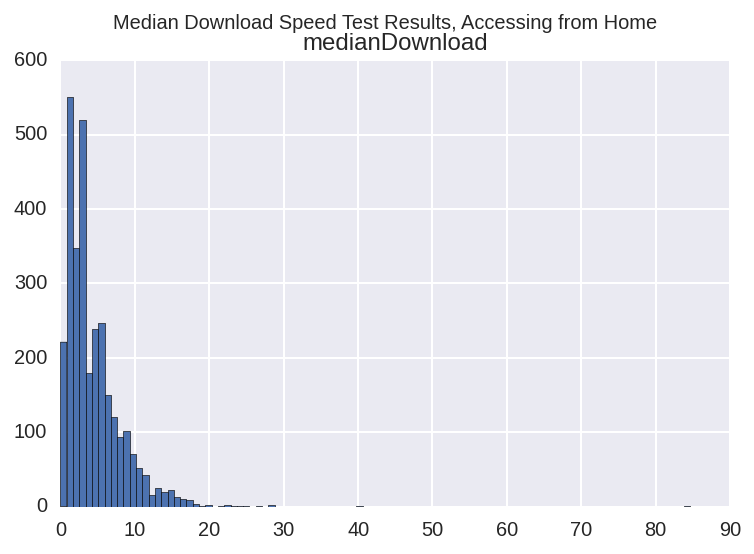

In [98]:
import pylab as pl
p1=speed_testDF[speed_testDF['accessingFrom']=='Home'][['geographyId','medianDownload']].hist(bins=100)
pl.suptitle('Median Download Speed Test Results, Accessing from Home')
p2=speed_testDF[speed_testDF['accessingFrom']=='Business'][['geographyId','medianDownload']].hist(bins=100)
p3=speed_testDF[speed_testDF['accessingFrom']=='Mobile'][['geographyId','medianDownload']].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e69d16510>]], dtype=object)

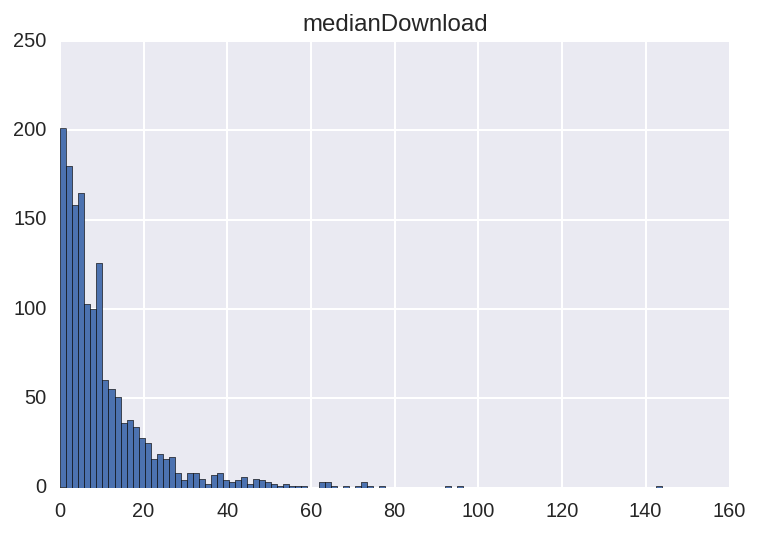

In [91]:
speed_testDF[speed_testDF['accessingFrom']=='Business'][['geographyId','medianDownload']].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e78194850>]], dtype=object)

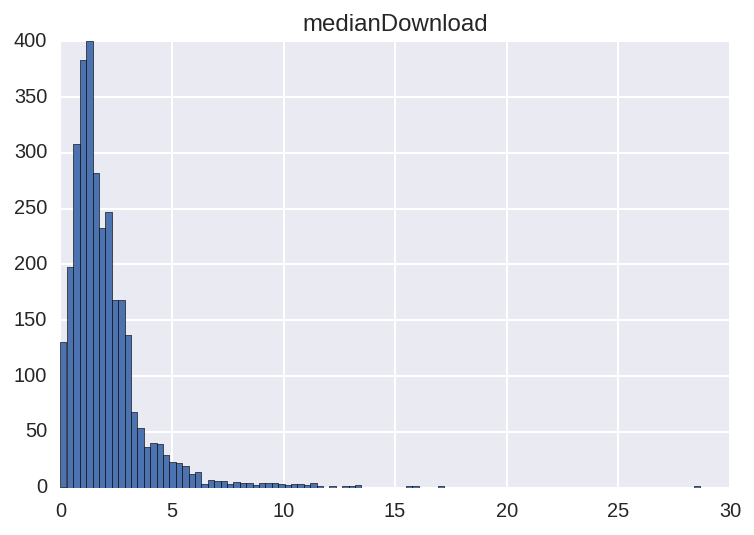

In [92]:
speed_testDF[speed_testDF['accessingFrom']=='Mobile'][['geographyId','medianDownload']].hist(bins=100)

Median Home download rate exported, plot created in R and uploaded to github.
https://github.com/SethPaul/broadband-project/blob/master/medianHome.svg

In [84]:
from IPython.display import SVG, display
def show_svg():
    display(SVG(url='https://raw.githubusercontent.com/SethPaul/broadband-project/master/medianHome.svg'))
show_svg()

In [101]:
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages') 
import vincent

In [102]:
#'merged' is the Pandas DataFrame
vis = vincent.Map(width=1000, height=800)
vis.tabular_data(speed_testDF[speed_testDF['accessingFrom']=='Home'], columns=['geographyId', 'medianDownload'])
vis.geo_data(projection='albersUsa', scale=1000, bind_data='data.id', counties=county_geo)
vis + (["#f5f5f5","#000045"], 'scales', 0, 'range')
vis.to_json(path)

TypeError: 'NoneType' object is not iterable

In [99]:
speed_testDF[speed_testDF['accessingFrom']=='Home']   \
[['geographyId','medianDownload']]

,geographyId,medianDownload
0,01001,4.97324
5,01003,2.76063
10,01005,7.14257
14,01007,2.69141
18,01009,2.15430
21,01011,13.83872
23,01013,1.50098
27,01015,4.52040
31,01017,15.20020
34,01019,2.53040


In [112]:
import vincent

In [117]:
county_topo='https://raw.githubusercontent.com/wrobstory/vincent_map_data/master/us_counties.topo.json'
geo_data = [{'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'}]

vis = vincent.Map(data=speed_testDF[speed_testDF['accessingFrom']=='Home'], geo_data=geo_data, scale=1100, projection='albersUsa',
          data_bind='medianDownload', data_key='geographyId',
          map_key={'counties': 'properties.FIPS'})
vis.marks[0].properties.enter.stroke_opacity = vincent.ValueRef(value=0.5)
vis.to_json('vega.json')
vis.display()